### 导入所需的包

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

#! 添加 numpy 和 matplotlib 库
import matplotlib.pyplot as plt
import numpy as np

### 构造数据集

In [2]:
# device = torch.device(
#     "cuda" if torch.cuda.is_available() else "cpu"
# )
device = torch.device(
    "mps" if torch.backends.mps.is_available else "cpu"
)  # for MacOS, GPU is mps instead of cuda

# TODO:解释参数含义，在?处填入合适的参数
batch_size = 64  # 每次小型迭代时传递给模型的样本数量
learning_rate = 0.001  # 学习率，即梯度下降算法中，负梯度的系数
num_epochs = 10 # 训练的轮数

# 转换为 pytorch 要求的 tensor 格式
transform = transforms.Compose([transforms.ToTensor()])

# 构造训练集和测试集(root可以换为你自己的路径)
trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
trainloader = DataLoader(
    trainset, batch_size=batch_size, shuffle=True
)  # mini-batch 在这里使用

testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


### 构造模型

In [3]:
#! 模型优化：可以尝试新的损失函数，新的优化器，新的网络结构等。
#! 这里我们添加了批量归一化层，dropout层，多加了一个线性层，使模型的准确率得到提升。
# 构造模型
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # 卷积层1
        self.bn1 = nn.BatchNorm2d(32)  # 批量归一化层1，可以加速收敛，提高精度
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 卷积层2
        self.bn2 = nn.BatchNorm2d(64)  # 批量归一化层2
        self.pool = nn.MaxPool2d(2, 2)  # 池化层
        self.dropout = nn.Dropout(
            0.25
        )  # Dropout层，随机丢弃一部分神经元，可以防止过拟合，
        self.fc1 = nn.Linear(64 * 8 * 8, 512)  # 全连接层1
        self.fc2 = nn.Linear(512, 10)  # 全连接层2

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.bn1(self.conv1(x))))
        x = self.pool(nn.functional.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 8 * 8)  # 展平
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

model = Network()  # 实例化模型
model.to(device)

Network(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

### 损失函数和优化器

In [4]:
# 损失函数
criterion = nn.CrossEntropyLoss()  # torch 中 交叉熵损失函数
# 优化器
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### 训练函数

In [5]:
# 训练：将循环封装进一个函数中
#! 为了图像可视化，我在这里将训练结果保存在一个列表中，最后返回
def train() -> list:
    results = []

    model.train()  # 模型设置为训练模式
    for epoch in range(num_epochs):  # 训练轮数
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(trainloader, 0):  # 每一轮分为 batch 个迭代
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # 梯度清零

            # 前馈
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # 反馈
            loss.backward()
            # 更新
            optimizer.step()

            # 计算每个 batch 的损失
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)  # 输出预测值
            total += labels.size(0)  # 标签总数
            correct += (predicted == labels).sum().item()  # 正确预测数

        accuracy = 100 * correct / total
        #! 将损失单独保存
        loss = running_loss / len(trainloader)

        #! 将损失和准确率分别保存在列表的两列中
        results.append([loss, accuracy])

        print(
            f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss:.4f}, Accuracy: {accuracy:.2f}%"
        )
    # print(results)

    return results

### 测试函数

In [6]:
def test():
    model.eval()  # 模型设置为评估模式
    correct = 0
    total = 0
    with torch.no_grad():  # 测试时不需计算梯度
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy of the model on the 10000 test images: {accuracy:.2f}%")

### 画图函数

In [7]:
def plot_results(results: list) -> None:
    #! 将列表转换为 numpy 数组
    results = np.array(results)

    #! 将 损失列 和 准确率列 分别提取出来
    loss = results[:, 0]
    accuracy = results[:, 1]

    #! 绘制一个柱状图，横坐标为 epoch，左纵坐标为 loss，右纵坐标为 accuracy
    epochs = np.arange(1, len(loss) + 1) # 创建一个包含从 1 到 len(loss) 的整数序列的 NumPy 数组
    width = 0.4  # 柱状图的宽度，即柱子的宽度和两个柱子之间的间隔

    _, axe1 = plt.subplots() # figure 是整个图形窗口，axe1 是第一个子图
    axe1.bar(epochs - width/2, loss, width, label='Loss', color='b')
    axe1.set_xlabel('Epoch')
    axe1.set_ylabel('Loss', color='b') # b - blue

    axe2 = axe1.twinx() # 创建第二个子图，其 x 轴不可见（与第一个子图共享 x 轴。）
    axe2.bar(epochs + width/2, accuracy, width, label='Accuracy', color='r')
    axe2.set_ylabel('Accuracy (%)', color='r') # r - red

    plt.show() # 显示图形窗口

#### for `numpy.arange()`:

```python
epochs = np.arange(1, len(loss) + 1) # 创建一个包含从 1 到 len(loss) 的整数序列的 NumPy 数组
```

* 使用 NumPy 的 arange 函数创建一个从 1 到 len(loss) 的整数序列数组。这个数组表示每个 epoch 的编号。

#### for `matplotlib.pyplot.subplots().bar()`, the docs say:

Make a bar plot(柱状图).

The bars are positioned at x with the given align\ment. Their dimensions are given by height and width. The vertical baseline is bottom (default 0).

Many parameters can take either a single value applying to all bars or a sequence of values, one for each bar.

Such as:

```python
axe1.bar(epochs - width/2, loss, width, label='Loss', color='b')
```

* `epochs - width/2` 是每个柱子的位置。
    * 每个 epoch 的编号减去柱状图的宽度的一半，这样可以让柱状图在 x = epochs 处居中显示。

#### for `matplotlib.pyplot.subplots()twinx()`, the docs say:

Create a twin Axes sharing the xaxis.

Create a new Axes with an **invisible x-axis** and an **independent y-axis positioned opposite to the original one (i.e. at right)**. The x-axis autoscale setting will be inherited from the original Axes. To ensure that the tick marks of both y-axes align, see ~matplotlib.ticker.LinearLocator.

### 主函数

Epoch [1/10], Loss: 1.3114, Accuracy: 53.03%
Epoch [2/10], Loss: 0.9864, Accuracy: 64.99%
Epoch [3/10], Loss: 0.8662, Accuracy: 69.51%
Epoch [4/10], Loss: 0.7814, Accuracy: 72.60%
Epoch [5/10], Loss: 0.6958, Accuracy: 75.30%
Epoch [6/10], Loss: 0.6337, Accuracy: 77.53%
Epoch [7/10], Loss: 0.5683, Accuracy: 79.82%
Epoch [8/10], Loss: 0.5142, Accuracy: 81.88%
Epoch [9/10], Loss: 0.4626, Accuracy: 83.41%
Epoch [10/10], Loss: 0.4109, Accuracy: 85.40%
[[1.3113827790750567, 53.032], [0.9864150337550951, 64.988], [0.8661594400015633, 69.514], [0.7814097360271932, 72.598], [0.6957812260102738, 75.3], [0.6336590186180666, 77.528], [0.568269621323594, 79.822], [0.5142310907697434, 81.882], [0.4625549253524112, 83.406], [0.41091199590803107, 85.398]]
Accuracy of the model on the 10000 test images: 70.20%


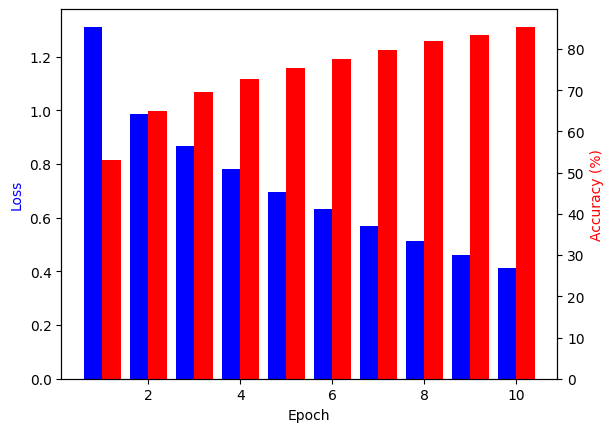

In [8]:
#! 主函数
def main() -> None:
    results = train()
    test()
    plot_results(results)

    return

if __name__ == "__main__":
    main()